In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

C:\Users\scanimage\AppData\Local\Temp\ipykernel_17924\912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import sys
import glob
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
sys.path.append(r"C:\Users\scanimage\Documents\JJM\post_cnmfe_analysis")
import dlc_utils as dlc
import os
import datetime
import math
from matplotlib.dates import DateFormatter, date2num

In [3]:
data_folder = r"F:\JJM\behavCam_videos_for_analysis\dSPNOpenFieldRecordings"

In [4]:
exTrack_location_files = glob.glob(data_folder+ r"\\**\\" + '*LocationOutput.csv')

In [5]:
sessionPath = exTrack_location_files[0]
print(sessionPath)

F:\JJM\behavCam_videos_for_analysis\dSPNOpenFieldRecordings\GRIN009_H13_M59_S14\concactenated_behavCam01_behavCam38_LocationOutput.csv


In [6]:
'\\'.join(sessionPath.split(os.sep)[:-1])+'\\timestamp.dat'

'F:\\JJM\\behavCam_videos_for_analysis\\dSPNOpenFieldRecordings\\GRIN009_H13_M59_S14\\timestamp.dat'

In [7]:
# load eZ track output and behavior camera timestamps from miniscope software 
ezTrackOutput = pd.read_csv(sessionPath)
timestampfile = pd.read_table('\\'.join(sessionPath.split(os.sep)[:-1])+'\\timestamp.dat')

In [8]:
# separate behavCam time stamps
behavCamTimeStamps = timestampfile[timestampfile['camNum'] == 1]

In [9]:
behavCamTimeStamps['frameNum'][0:len(ezTrackOutput)]

1            1
3            2
4            3
6            4
7            5
         ...  
63311    37996
63312    37997
63314    37998
63316    37999
63317    38000
Name: frameNum, Length: 38000, dtype: int64

In [10]:
# get times of frames
behavCamTimes = behavCamTimeStamps['sysClock']
# set 1st frame to 0 
behavCamTimes[1] = 0 
# reset index to 0 
behavCamTimes = behavCamTimes.reset_index()

C:\Users\scanimage\AppData\Local\Temp\ipykernel_17924\501050040.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavCamTimes[1] = 0


In [11]:
# delta T between frames for analyzed videos 
behavCamFrameTimeDelta = behavCamTimes['sysClock'].diff()[0:len(ezTrackOutput)]

In [12]:
# get velocity from frame times 
velocity = abs(ezTrackOutput['Distance_cm'].diff())/(behavCamFrameTimeDelta/1000)

In [13]:
# data frame of mouse velocity 
veloctiyDataFrame = pd.concat([ezTrackOutput[['Frame', 'X', 'Y', 'Distance_px', 'Distance_cm']], 
                               behavCamTimes[0:len(ezTrackOutput)]['sysClock'],
                               pd.DataFrame(velocity, columns=['Velocity'])], axis=1)

In [14]:
#frame rate for behavCam 
veloctiyDataFrame['sysClock'].diff().mean()

33.33490355009342

In [15]:
# create time delta for behavior index
# behavCam for v3 should record at 30 fps, can verify in timestamp file, check this is set correctly in concactenated videos
veloctiyDataFrame = veloctiyDataFrame.set_index(pd.to_timedelta(np.linspace(0, (len(veloctiyDataFrame)-1)*(1/30), len(veloctiyDataFrame)), unit='s'))
veloctiyDataFrame

,Frame,X,Y,Distance_px,Distance_cm,sysClock,Velocity
0 days 00:00:00,0,233.259740,204.564935,0.000000,0.000000,0,NaN
0 days 00:00:00.033333333,1,232.814930,205.394168,0.941001,0.085463,16,5.341447
0 days 00:00:00.066666667,2,232.370370,203.614815,1.834048,0.166571,50,2.385524
0 days 00:00:00.100000,3,232.253968,204.087302,0.486614,0.044195,94,2.781272
0 days 00:00:00.133333333,4,232.253968,204.087302,0.000000,0.000000,122,1.578393
...,...,...,...,...,...,...,...
0 days 00:21:06.500000,37995,203.944184,211.734934,0.830215,0.075401,1266561,1.393085
0 days 00:21:06.533333332,37996,204.209040,211.996660,0.372357,0.033818,1266594,1.260103
0 days 00:21:06.566666667,37997,203.756154,211.635547,0.579231,0.052607,1266626,0.587145
0 days 00:21:06.600000,37998,203.532126,212.112719,0.527145,0.047876,1266659,0.143349


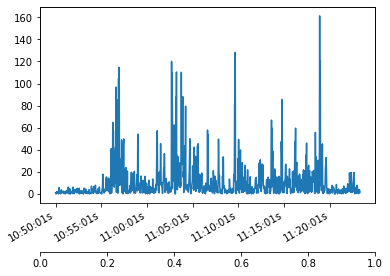

In [16]:
# plot velocity results
xRangeFrames=(19500,20500)
y = veloctiyDataFrame['Velocity'][xRangeFrames[0]:xRangeFrames[1]]
#recording_start_time = datetime.datetime.fromtimestamp(abs(timestampfile[timestampfile['camNum'] == 1]['sysClock'][1]))
#plot x axis time
recording_start_time = datetime.datetime(1970, 1, 1, hour=0, minute=0, second=0, microsecond=0)
x = [recording_start_time+veloctiyDataFrame.index[i] for i in range(len(veloctiyDataFrame.index))][xRangeFrames[0]:xRangeFrames[1]]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
fig.subplots_adjust(bottom=0.2)

myFmt = DateFormatter("%M:%S:%ms")
ax1.xaxis.set_major_formatter(myFmt)
ax1.plot(x, y)
plt.gcf().autofmt_xdate()

# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.25))

plt.show()



In [17]:
veloctiyDataFrame[xRangeFrames[0]:xRangeFrames[1]]

,Frame,X,Y,Distance_px,Distance_cm,sysClock,Velocity
0 days 00:10:50,19500,251.984433,114.288943,0.299619,0.027212,649985,1.127443
0 days 00:10:50.033333333,19501,251.785057,114.635690,0.399981,0.036327,650016,0.294033
0 days 00:10:50.066666667,19502,252.143379,114.533146,0.372706,0.033850,650048,0.077409
0 days 00:10:50.100000,19503,251.842214,114.614794,0.312036,0.028340,650080,0.172193
0 days 00:10:50.133333333,19504,252.670471,113.543640,1.354023,0.122974,650128,1.971559
...,...,...,...,...,...,...,...
0 days 00:11:23.166666667,20495,295.157357,339.291562,0.119804,0.010881,683152,3.110863
0 days 00:11:23.200000,20496,293.857256,340.029047,1.494706,0.135751,683184,3.902205
0 days 00:11:23.233333333,20497,292.094523,339.536097,1.830363,0.166236,683216,0.952653
0 days 00:11:23.266666667,20498,291.402495,339.510680,0.692494,0.062893,683248,3.229467


In [18]:
#resample velocity for thresholding/smoothing 
velocityResampled = veloctiyDataFrame.resample('2S').sum()
len(velocityResampled)
#based on this define a threshold of 20 cm in 2 seconds for movement
def thresholdVelocity(row):
    if row['Distance_cm']>20:
        val = 1
    else:
        val = 0 
    return(val)
#apply threshold function to dataframe, creates "Moving" threshold column
velocityResampled['Moving'] = velocityResampled.apply(thresholdVelocity, axis=1)

In [19]:
#upsample velocity to match orignial sampling rate, backfill new rows to classify upsampled indicies as moving/rest
velocityUpsampled_20Hz = velocityResampled.resample('.05S').bfill()
#upsample velocity to match Ca2+ data analysis rate 
velocityUpsampled_5Hz = velocityResampled.resample('.2S').bfill()

In [20]:
velocityUpsampled_20Hz.head()

,Frame,X,Y,Distance_px,Distance_cm,sysClock,Velocity,Moving
0 days 00:00:00,1770,13985.724653,12311.884029,52.996048,4.813180,58277,114.684812,0
0 days 00:00:00.050000,5370,13992.433240,12314.291079,45.745839,4.154705,178233,89.504429,0
0 days 00:00:00.100000,5370,13992.433240,12314.291079,45.745839,4.154705,178233,89.504429,0
0 days 00:00:00.150000,5370,13992.433240,12314.291079,45.745839,4.154705,178233,89.504429,0
0 days 00:00:00.200000,5370,13992.433240,12314.291079,45.745839,4.154705,178233,89.504429,0


In [21]:
# get frame indicies at original rate 
velocityUpsampled_20Hz[velocityUpsampled_20Hz['Moving']==1].index

TimedeltaIndex(['0 days 00:05:28.050000', '0 days 00:05:28.100000',
                '0 days 00:05:28.150000', '0 days 00:05:28.200000',
                '0 days 00:05:28.250000', '0 days 00:05:28.300000',
                '0 days 00:05:28.350000', '0 days 00:05:28.400000',
                '0 days 00:05:28.450000', '0 days 00:05:28.500000',
                ...
                '0 days 00:18:19.550000', '0 days 00:18:19.600000',
                '0 days 00:18:19.650000', '0 days 00:18:19.700000',
                '0 days 00:18:19.750000', '0 days 00:18:19.800000',
                '0 days 00:18:19.850000', '0 days 00:18:19.900000',
                '0 days 00:18:19.950000',        '0 days 00:18:20'],
               dtype='timedelta64[ns]', length=3600, freq=None)

In [22]:
# get indicies of moving periods at both 20Hz and 5Hz sample rates, save to csv files
movingIndicies_20Hz = pd.DataFrame([velocityUpsampled_20Hz.index.get_loc(velocityUpsampled_20Hz[velocityUpsampled_20Hz['Moving']==1].index[i]) 
              for i in range(len(velocityUpsampled_20Hz[velocityUpsampled_20Hz['Moving']==1].index))],
             columns=['MovingIndicies'])
movingIndicies_5Hz = pd.DataFrame([velocityUpsampled_5Hz.index.get_loc(velocityUpsampled_5Hz[velocityUpsampled_5Hz['Moving']==1].index[i]) 
              for i in range(len(velocityUpsampled_5Hz[velocityUpsampled_5Hz['Moving']==1].index))],
             columns=['MovingIndicies'])



In [23]:
movingIndicies_20Hz.to_csv(os.path.split(sessionPath)[0]+'\\'+os.path.split(sessionPath)[0].split('\\')[-1]+'_movingFrameIndicies20Hz.csv')
movingIndicies_5Hz.to_csv(os.path.split(sessionPath)[0]+'\\'+os.path.split(sessionPath)[0].split('\\')[-1]+'_movingFrameIndicies5Hz.csv')

In [24]:
## smooth velocity by upsampling 

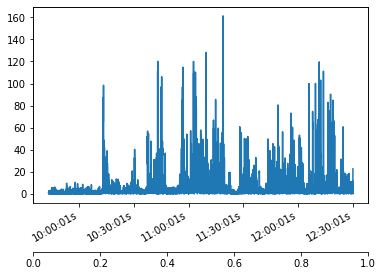

In [25]:
xRangeFrames=(17500,22500)
y = veloctiyDataFrame['Velocity'][xRangeFrames[0]:xRangeFrames[1]]
#recording_start_time = datetime.datetime.fromtimestamp(abs(timestampfile[timestampfile['camNum'] == 1]['sysClock'][1]))
#plot x axis time
recording_start_time = datetime.datetime(1970, 1, 1, hour=0, minute=0, second=0, microsecond=0)
x = [recording_start_time+veloctiyDataFrame.index[i] for i in range(len(veloctiyDataFrame.index))][xRangeFrames[0]:xRangeFrames[1]]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
fig.subplots_adjust(bottom=0.2)

myFmt = DateFormatter("%M:%S:%ms")
ax1.xaxis.set_major_formatter(myFmt)
ax1.plot(x, y)
plt.gcf().autofmt_xdate()

# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.25))

plt.show()

In [26]:
veloctiyDataFrame

,Frame,X,Y,Distance_px,Distance_cm,sysClock,Velocity
0 days 00:00:00,0,233.259740,204.564935,0.000000,0.000000,0,NaN
0 days 00:00:00.033333333,1,232.814930,205.394168,0.941001,0.085463,16,5.341447
0 days 00:00:00.066666667,2,232.370370,203.614815,1.834048,0.166571,50,2.385524
0 days 00:00:00.100000,3,232.253968,204.087302,0.486614,0.044195,94,2.781272
0 days 00:00:00.133333333,4,232.253968,204.087302,0.000000,0.000000,122,1.578393
...,...,...,...,...,...,...,...
0 days 00:21:06.500000,37995,203.944184,211.734934,0.830215,0.075401,1266561,1.393085
0 days 00:21:06.533333332,37996,204.209040,211.996660,0.372357,0.033818,1266594,1.260103
0 days 00:21:06.566666667,37997,203.756154,211.635547,0.579231,0.052607,1266626,0.587145
0 days 00:21:06.600000,37998,203.532126,212.112719,0.527145,0.047876,1266659,0.143349


In [48]:
downsampledDataFrame = veloctiyDataFrame.resample('.2S').mean()[['X', 'Y']]
# calculate new euclidean distance based on mean values here 
downsampledDataFrame

,X,Y
0 days 00:00:00,232.642780,204.327223
0 days 00:00:00.200000,233.129633,205.614748
0 days 00:00:00.400000,233.723151,205.275369
0 days 00:00:00.600000,233.631845,205.291692
0 days 00:00:00.800000,233.732018,205.220033
...,...,...
0 days 00:21:05.800000,204.668333,213.348752
0 days 00:21:06,203.728021,211.738159
0 days 00:21:06.200000,204.122481,211.834786
0 days 00:21:06.400000,203.864261,211.889510


In [49]:
def euclideanDistance(row):
    return(math.sqrt(row['X']**2+row['Y']**2))
    
downsampledDataFrame['smoothedVelocity'] = downsampledDataFrame.diff().apply(euclideanDistance, axis=1)

In [68]:
#downsample once more to 1S as a "median filter"
downsampledMedian = downsampledDataFrame.resample('2S').median()
#downsampledMedian

In [69]:
downsampledMedian.resample('.2S').bfill()

,X,Y,smoothedVelocity
0 days 00:00:00,232.965915,205.204761,0.398895
0 days 00:00:00.200000,233.169828,205.367158,0.476901
0 days 00:00:00.400000,233.169828,205.367158,0.476901
0 days 00:00:00.600000,233.169828,205.367158,0.476901
0 days 00:00:00.800000,233.169828,205.367158,0.476901
...,...,...,...
0 days 00:21:05.200000,203.796141,211.862148,0.335039
0 days 00:21:05.400000,203.796141,211.862148,0.335039
0 days 00:21:05.600000,203.796141,211.862148,0.335039
0 days 00:21:05.800000,203.796141,211.862148,0.335039


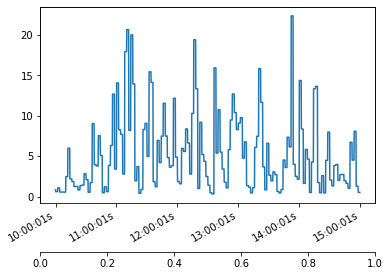

In [72]:
velocity_resampled = downsampledMedian.resample('.2S').bfill()
xRangeFrames=(3000,4500)
columnToPlot = 'smoothedVelocity'
y = velocity_resampled[columnToPlot][xRangeFrames[0]:xRangeFrames[1]]
#recording_start_time = datetime.datetime.fromtimestamp(abs(timestampfile[timestampfile['camNum'] == 1]['sysClock'][1]))
#plot x axis time
recording_start_time = datetime.datetime(1970, 1, 1, hour=0, minute=0, second=0, microsecond=0)
x = [recording_start_time+velocity_resampled.index[i] for i in range(len(velocity_resampled.index))][xRangeFrames[0]:xRangeFrames[1]]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
fig.subplots_adjust(bottom=0.2)

myFmt = DateFormatter("%M:%S:%ms")
ax1.xaxis.set_major_formatter(myFmt)
ax1.plot(x, y)
plt.gcf().autofmt_xdate()

# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.25))

plt.show()

In [82]:
velocity_resampled[(velocity_resampled['smoothedVelocity']>0) & (velocity_resampled['smoothedVelocity']<0.5)]


,X,Y,smoothedVelocity
0 days 00:00:00,232.965915,205.204761,0.398895
0 days 00:00:00.200000,233.169828,205.367158,0.476901
0 days 00:00:00.400000,233.169828,205.367158,0.476901
0 days 00:00:00.600000,233.169828,205.367158,0.476901
0 days 00:00:00.800000,233.169828,205.367158,0.476901
...,...,...,...
0 days 00:21:05.200000,203.796141,211.862148,0.335039
0 days 00:21:05.400000,203.796141,211.862148,0.335039
0 days 00:21:05.600000,203.796141,211.862148,0.335039
0 days 00:21:05.800000,203.796141,211.862148,0.335039


In [84]:
# define velocity bins and save output to csv files for clustering analysis
velocityBins = [(0, 0.5), (0.5, 1), (1, 2), (2, 5), (5, 10), (10, math.inf)]

,X,Y,smoothedVelocity
0 days 00:00:00,232.965915,205.204761,0.398895
0 days 00:00:00.200000,233.169828,205.367158,0.476901
0 days 00:00:00.400000,233.169828,205.367158,0.476901
0 days 00:00:00.600000,233.169828,205.367158,0.476901
0 days 00:00:00.800000,233.169828,205.367158,0.476901
...,...,...,...
0 days 00:21:05.200000,203.796141,211.862148,0.335039
0 days 00:21:05.400000,203.796141,211.862148,0.335039
0 days 00:21:05.600000,203.796141,211.862148,0.335039
0 days 00:21:05.800000,203.796141,211.862148,0.335039


In [98]:
#get indicies corresponding to velocity bins 
indiciesVbin0 = pd.DataFrame([velocity_resampled.index.get_loc(velocity_resampled[(velocity_resampled['smoothedVelocity']>0) & (velocity_resampled['smoothedVelocity']<0.5)].index[i]) 
 for i in range(len(velocity_resampled[(velocity_resampled['smoothedVelocity']>0) & (velocity_resampled['smoothedVelocity']<0.5)].index))], columns=['Indicies'])
indiciesVbin1 = pd.DataFrame([velocity_resampled.index.get_loc(velocity_resampled[(velocity_resampled['smoothedVelocity']>0.5) & (velocity_resampled['smoothedVelocity']<1)].index[i]) 
 for i in range(len(velocity_resampled[(velocity_resampled['smoothedVelocity']>0.5) & (velocity_resampled['smoothedVelocity']<1)].index))], columns=['Indicies'])
indiciesVbin2 = pd.DataFrame([velocity_resampled.index.get_loc(velocity_resampled[(velocity_resampled['smoothedVelocity']>1) & (velocity_resampled['smoothedVelocity']<2)].index[i]) 
 for i in range(len(velocity_resampled[(velocity_resampled['smoothedVelocity']>1) & (velocity_resampled['smoothedVelocity']<2)].index))], columns=['Indicies'])
indiciesVbin3 = pd.DataFrame([velocity_resampled.index.get_loc(velocity_resampled[(velocity_resampled['smoothedVelocity']>2) & (velocity_resampled['smoothedVelocity']<5)].index[i]) 
 for i in range(len(velocity_resampled[(velocity_resampled['smoothedVelocity']>2) & (velocity_resampled['smoothedVelocity']<5)].index))], columns=['Indicies'])
indiciesVbin4 = pd.DataFrame([velocity_resampled.index.get_loc(velocity_resampled[(velocity_resampled['smoothedVelocity']>5) & (velocity_resampled['smoothedVelocity']<10)].index[i]) 
 for i in range(len(velocity_resampled[(velocity_resampled['smoothedVelocity']>5) & (velocity_resampled['smoothedVelocity']<10)].index))], columns=['Indicies'])
indiciesVbin5 = pd.DataFrame([velocity_resampled.index.get_loc(velocity_resampled[(velocity_resampled['smoothedVelocity']>10) & (velocity_resampled['smoothedVelocity']<math.inf)].index[i]) 
 for i in range(len(velocity_resampled[(velocity_resampled['smoothedVelocity']>10) & (velocity_resampled['smoothedVelocity']<math.inf)].index))], columns=['Indicies'])

'F:\\JJM\\behavCam_videos_for_analysis\\dSPNOpenFieldRecordings\\GRIN009_H13_M59_S14\\'

In [99]:
#save to csv files 
basePath=r'F:\\JJM\\behavCam_videos_for_analysis\\dSPNOpenFieldRecordings'
indiciesVbin0.to_csv(basePath+'\\'+os.path.split(sessionPath)[0].split('\\')[-1]+'_movingFrameIndicies5Hz_vbin0.csv')
indiciesVbin1.to_csv(basePath+'\\'+os.path.split(sessionPath)[0].split('\\')[-1]+'_movingFrameIndicies5Hz_vbin1.csv')
indiciesVbin2.to_csv(basePath+'\\'+os.path.split(sessionPath)[0].split('\\')[-1]+'_movingFrameIndicies5Hz_vbin2.csv')
indiciesVbin3.to_csv(basePath+'\\'+os.path.split(sessionPath)[0].split('\\')[-1]+'_movingFrameIndicies5Hz_vbin3.csv')
indiciesVbin4.to_csv(basePath+'\\'+os.path.split(sessionPath)[0].split('\\')[-1]+'_movingFrameIndicies5Hz_vbin4.csv')
indiciesVbin5.to_csv(basePath+'\\'+os.path.split(sessionPath)[0].split('\\')[-1]+'_movingFrameIndicies5Hz_vbin5.csv')

In [114]:
indiciesVbin0

,Indicies
0,0
1,1
2,2
3,3
4,4
...,...
1326,6326
1327,6327
1328,6328
1329,6329


In [ ]:
#move to quest
#res_files=8f796c9e-f5c8-11e5-9842-22000b9da45e
#quest=d5990400-6d04-11e5-ba46-22000b92c6ec
#res_files_base_dir = '8f796c9e-f5c8-11e5-9842-22000b9da45e:/rdss/jma819/fsmresfiles/Projects/JJM/MiniscopeMovies/scope_data/'
#quest_dir = 'd5990400-6d04-11e5-ba46-22000b92c6ec:/projects/b1118/behaviorvideos/timestampfiles/'

In [ ]:
#for session in list(time_stamp_file_locations.keys()):
#    transfer_info = res_files_base_dir+time_stamp_file_locations[session]+' '+quest_dir+session+'_timestamp.dat'
#    !eval "globus transfer" $transfer_info

In [ ]:
##frame by frame alignment to miniscope camera

sessions = [f_path.split('/')[-1].rstrip('_raw_trace.csv') for f_path in mm_raw_traces]

sessions = ['GRIN039_H14_M8_S53', 'GRIN026_H16_M35_S34', 'GRIN032_H16_M49_S22']

for session in sessions:
    print(session)
    timestampfile = '/projects/b1118/behaviorvideos/timestampfiles/'+session+'_timestamp.dat'
    frame_clock_df = pd.read_table(timestampfile)
    output_directory = '/projects/b1118/miniscope/analysis/compiled_data/mm_tracking_output/'

    Cam0_timestamps = frame_clock_df[frame_clock_df['camNum'] == 0]  
    Cam1_timestamps = frame_clock_df[frame_clock_df['camNum'] == 1]
    #beavCam is usually faster framerate 
    if Cam1_timestamps['sysClock'].iloc[1:].diff().mean()<Cam0_timestamps['sysClock'].iloc[1:].diff().mean():
        msCam_camnum=0
        behavCam_camnum=1
    elif Cam0_timestamps['sysClock'].iloc[1:].diff().mean()<Cam1_timestamps['sysClock'].iloc[1:].diff().mean():
        msCam_camnum=1
        behavCam_camnum=0

    raw_trace = pd.read_csv(data_folder+session+'_raw_trace.csv', names=['velocity'])
    raw_trace_filtered = pd.read_csv(data_folder+session+'_raw_trace_median_filter.csv', names=['velocity(20_Hz_filtered)'])
    speed_trace = pd.read_csv(data_folder+session+'_speedtrace.csv', names=['speed_trace(velocity_5Hz_filtered)'])
    raw_traces = pd.concat([raw_trace, raw_trace_filtered], axis=1)

    # align the raw traces for comparison

    mm_tracking_aligned = dlc.downsample_mmtracking(raw_traces, timestampfile, msCam_camnum, behavCam_camnum)

    # convert to timedelta for downsampling 
    aligned_td = mm_tracking_aligned.set_index(pd.to_timedelta(np.linspace(0, mm_tracking_aligned['sys_clock_behavCam'].values[-1]/1000, len(mm_tracking_aligned)), unit='s'), drop=False)
    aligned_td.to_csv(output_directory+session+'_mm_tracking_foranalysis_unsmoothed'+'.csv')